# Parallelisation

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukeconibear/swd6_hpp/blob/main/docs/05_parallelisation.ipynb)

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    %pip install dask[dataframe] joblib ray

## What is it?

Parallelisation divides a large problem into many smaller ones and solves them *simultaneously*.

This *divides up the time/space complexity*.

These divided up tasks are centrally managed by a scheduler.
    
The work can be split across:

- Multiple [processes](https://en.wikipedia.org/wiki/Process_(computing)) (cores)
    - A process is the instance of a computer program.
    - This program is being executed by one or many threads.
    - Useful for compute-bound problems.
- Multiple [threads](https://en.wikipedia.org/wiki/Thread_(computing)) (parts of processes)
    - A thread of execution is the smallest sequence of programmed instructions.
    - Useful for memory-bound problems.  

```{image} images/process-threads.png
:height: 300px
:name: process-threads
```

*[Image source](https://en.wikipedia.org/wiki/Thread_(computing))*

## Parallelising a Python?

Python itself is not designed for massive scalability and controls threads preemptively using the [Global Interpreter Lock, GIL](https://wiki.python.org/moin/GlobalInterpreterLock).  

(The GIL prevents running on mutliple threads simutaneously.)  

This has lead many libraries to work around this using C/C++ backends.  

Some options include:
- [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) for creating a pool of asynchronous workers. 
- [joblib](https://joblib.readthedocs.io/en/latest/) for creating lightweight pipelines that help with embaressingly parallel tasks.
- [asyncio](https://docs.python.org/3/library/asyncio.html) for concurrent programs, especially ones that are input/output bound.  
- [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html#module-concurrent.futures) for launching parallel tasks.  

These options work well for the CPU cores on your machine, though not really beyond that.  

## [Dask](https://docs.dask.org/en/latest/)

Dask has great features, excellent documentation, and a familiar API.

It works through creating and computing [task graphs](https://docs.dask.org/en/stable/graphs.html). 

Task graphs have nodes (functions) and edges (objects). 

For example, the task graph might be:

- [Embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel) (apply one function to many pieces of data independently).
- [MapReduce](https://en.wikipedia.org/wiki/MapReduce) (map a function to the data and reduce / summarise the output).

![dask-task-graphs.svg](images/dask-task-graphs.svg)  

*[Image source](https://docs.dask.org/en/stable/graphs.html)*

These task graphs are executed by a [scheduler](https://docs.dask.org/en/stable/scheduling.html).

_Note, this is separate to [ARC's scheduler](https://arcdocs.leeds.ac.uk/usage/start.html)._

The resources used by this scheduler are managed by a cluster.  

There are two main types of Dask scheduler which can [deploy jobs](https://docs.dask.org/en/stable/deploying.html):

- [Single machine](https://docs.dask.org/en/stable/deploying-python.html)
    - Cluster manager: [`LocalCluster()`](http://distributed.dask.org/en/stable/api.html#distributed.LocalCluster)
    - Simpler.
    - For your laptop or a local server.
    - Test things out here first.
- [Distributed](https://docs.dask.org/en/stable/deploying-hpc.html)
    - Cluster manager: [`SGECluster()`](http://jobqueue.dask.org/en/latest/generated/dask_jobqueue.SGECluster.html), [`SLURMCluster()`](http://jobqueue.dask.org/en/latest/generated/dask_jobqueue.SLURMCluster.html)
    - More complex.
    - For a cluster on a high performance computer (HPC) (e.g., SGE, SLURM), Kubernetes, or cloud.
    - Once working correctly on a single machine, move over to distributed.
    

To simplify things, you can think of the scheduler and the cluster manager as the same thing (i.e., the Dask manager). You then connect to this Dask manager using a client to make workers.

![dask-cluster-manager.svg](images/dask-cluster-manager.svg)  

*[Image source](https://docs.dask.org/en/stable/deploying.html)*

### [Single machine](https://docs.dask.org/en/stable/deploying-python.html)

In [2]:
if not IN_COLAB:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()  # the Dask manager itself
    client = Client(cluster)  # connecting to this Dask manager to see whats doing

In [3]:
# if not in colab, can render the client and cluster information
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 30.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42377,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 30.94 GiB
Comm: tcp://127.0.0.1:35229,Total threads: 2
Dashboard: http://127.0.0.1:40515/status,Memory: 7.74 GiB
Nanny: tcp://127.0.0.1:38503,


If instead you wanted multiple threads, then could specify this in the Client instance:

```python
client = Client(processes=False, threads_per_worker=4, n_workers=1)
```

*Note (important!), always need to close down the client and cluster at the end:*

```python
client.close()
cluster.close()
```

#### Applications

There are many ways you can use Dask.

For example, there are:

- [dask.array](https://examples.dask.org/array.html) for NumPy
- [dask.dataframe](https://examples.dask.org/dataframe.html) for Pandas
- [dask.bag](https://examples.dask.org/bag.html) to iterate over a bag of independent objects (embarrassingly parallel).
- And others (see the documentation).
- Also, Dask is under the hood for many libraries e.g., [xarray](http://xarray.pydata.org/en/stable/dask.html), [iris](https://scitools.org.uk/iris/docs/v2.4.0/userguide/real_and_lazy_data.html), [scikit-learn](https://ml.dask.org/).

Here, out example is going to do some maths on arrays. Don't worry about what it is. Just focus on the Dask bits.

In [4]:
import numpy as np
import dask.array as da

```{warning}
Parallelised code often introduces overheads e.g., the Dask manager.  

For small jobs, these can take up a large relative portion of the resources, making the job inefficient. Hence, it is worthwhile ensuring that the job is big enough that these overheads are small in comparison. The examples here in this tutorial are on the small side purely for teaching purposes.
```

In [5]:
x = da.random.random(
    (10_000, 10_000, 10), 
    chunks=(1_000, 1_000, 5))
y = da.random.random(
    (10_000, 10_000, 10), 
    chunks=(1_000, 1_000, 5))
z = (da.arcsin(x) + da.arccos(y)).sum(axis=(1, 2))

No work has happened yet.

All that has been done is that a task graph was created. This contains the future work that we will eventually compute.

So, if I take a look at `z`, I can see that it will eventually be a NumPy array, but at the moment it is lots of Dask chunks that are lazily loaded.

In [6]:
z

dask.array<sum-aggregate, shape=(10000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

The first thing to do is often to take a [look at the task graph](https://docs.dask.org/en/stable/graphviz.html).

This is done by called the `.visualise()` method on the Dask object.

This may help find potential bottlenecks.

For example:

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.333945 to fit


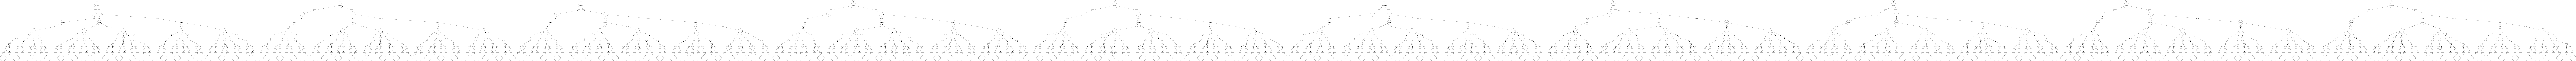

In [7]:
z.visualize()

These can often be too large for the Jupyter cell. 

Instead, we can look at the copy saved in this folder under [`mydask.png`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/mydask.png).  

We can see that this large graph has lots of parallel tasks!

Before we compute anything, it's helpful to setup Dask's live dashboard.

#### [Local profiling and diagnostics](https://docs.dask.org/en/stable/diagnostics-local.html)

Many of the profiling tools we looked at earlier don't work well with parallel code.

Dask provides its own useful tools.

##### [Interactive dashboard](https://docs.dask.org/en/stable/diagnostics-distributed.html)

The Dask dashboard provides live feedback and diagnostics in many plots and tables using [Bokeh](https://docs.bokeh.org/en/latest/).

First, get the Dask dashboard address (normally `http://localhost:8787/status`):

In [8]:
print(client.dashboard_link)

http://127.0.0.1:8787/status


Either load that link in a browser or copy the address into the [Dask Lab Extension](https://github.com/dask/dask-labextension).

The Dask Lab Extension should now show all of the client and cluster information.

You can place some of these panels to the right hand side e.g.,:

- Task Stream
- Progress
- Workers

**Task Stream**
- Each row is the activity on a process (core) or thread within the cluster over time.
- Each rectangle is one task.
- The different colours and different *types* of work:
    - Idle (white)
    - Serialisation (grey)
    - Communication (red)
    - Disk input/output (orange)
    - Other tasks e.g., computation (other colours)
    
![SegmentLocal](images/bokeh-task-stream.gif "segment")
*[Image source](http://distributed.dask.org/en/stable/diagnosing-performance.html)*

**Progress**
- Progresses from left to right, showing the number of tasks complete and remaining.
- Same colours as above, with grey for ready to run, darker colours for data in memory, and lighter colours for complete tasks released from memory.

![SegmentLocal](images/bokeh-progress-large.gif "segment")
*[Image source](http://matthewrocklin.com/blog/work/2016/09/12/dask-distributed-release-1.13.0)*

**Workers**
- Shows the CPU percentage use (also per worker).
- Shows the memory percentage use (also per worker).

*Remember, this is Dask's view of the world, so it may be different to the view from your laptop or HPC.*  

There is lots of other useful information, such as ([video demonstration](https://www.youtube.com/watch?v=N_GqzcuGLCY)):

- [Profiler](http://distributed.dask.org/en/stable/diagnosing-performance.html#statistical-profiling)
    - Statistical (sampling every 10ms) capture of the call stack from the Dask schedulers perspective.
    
![SegmentLocal](images/daskboard-profile.gif "segment")

*[Image source](http://distributed.dask.org/en/stable/diagnosing-performance.html)*

- System
- Logs
- Individual workers
- etc.

Now, when you `.compute()` the task graph, you can view the progress in these dashboard panels.

In [9]:
result = z.compute()

And now the result is converted to a NumPy array in memory.

In [10]:
type(result)

numpy.ndarray

In [11]:
result

array([157018.0584079 , 157110.649141  , 157287.72736279, ...,
       157009.27095739, 157524.29093676, 157144.2235107 ])

```{admonition} Question
What did our Dask Dashboard show?
```

```{hint}
:class: dropdown

Look at the rectangles in the Task Stream.

```

```{admonition} Solution
:class: dropdown

Our specific results show us that:

- All workers were full with numerical tasks (i.e., no white/red blocks).
- This utilises the CPU cores well.
- Also, the CPU percentage for the workers increased to ~100 % during the computation.

```

```{admonition} Exercise

Which is of the 3 examples below is most efficient and why?

```

```{hint}
:class: dropdown

Use `%%time`.

```

**Example 1**

Many, small chunks

In [12]:
x = da.random.random(10_000_000, chunks=(1_000,))
y = x.sum().compute()

**Example 2**

Fewer, large chunks

In [13]:
x = da.random.random(10_000_000, chunks=(100_000,))
y = x.sum().compute()

**Example 3**

Use NumPy

In [14]:
x = np.random.random(10_000_000)
y = x.sum()

```{admonition} Solution
:class: dropdown

- Dask introduces overhead to parallelise work (i.e., the scheduler and client).
- Hence, Dask is inefficient (i.e., the workers are under-utilised) when doing lots of very small computations.
- Consider using fewer, larger chunks to reduce this overhead.
- Consider if parallelisation is really needed.

```

If you want a shareable report of this interactive dashboard, you can use the [performance report](http://distributed.dask.org/en/latest/diagnosing-performance.html#performance-reports) context manager.

In [15]:
from dask.distributed import performance_report

In [16]:
with performance_report(filename="dask-report.html"):
    result = z.compute()

Can then view this performance report here or in a browser:

In [18]:
from IPython.display import display, HTML

display(HTML(filename='dask-report.html'))

This can also be shared with colleagues:

- Create a [Gist](https://gist.github.com/).
- Copy the contents of the [`dask-report.html`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/dask-report.html) into here.
- Host the file e.g., by providing the `Raw` address to [raw.githack.com](https://raw.githack.com/).

For example, for this report click [here](https://gistcdn.githack.com/lukeconibear/05f878a8b149178524c1508c37e204a3/raw/87f1f7c92f821773ccb67631f8757d1ca4a2404b/dask-report.html).

##### [**Static profilers**](https://docs.dask.org/en/stable/diagnostics-local.html)

There are also a range of simpler, static profilers, such as:

- [`Profiler()`](https://docs.dask.org/en/stable/diagnostics-local.html#dask.diagnostics.Profiler) for task execution.
- [`ResourceProfiler()`](https://docs.dask.org/en/stable/diagnostics-local.html#dask.diagnostics.ResourceProfiler) for resource use.
- [`CacheProfiler()`](https://docs.dask.org/en/stable/diagnostics-local.html#dask.diagnostics.CacheProfiler) for scheduler cache.

When you're happy that everything is correct on a single machine, you can move over to distributed.

**Remember(!) to close down the local client and cluster.**

In [19]:
if not IN_COLAB:   
    client.close()
    cluster.close()

### [Distributed](https://docs.dask.org/en/stable/deploying-hpc.html)

#### [Dask-MPI](http://mpi.dask.org/en/latest/)

Uses the [`mpi4py`](https://mpi4py.readthedocs.io/en/stable/) package and MPI to distribute the workers (not communication).  

[MPI (Message Passing Interface)](https://en.wikipedia.org/wiki/Message_Passing_Interface) is where many systems send and receive messages (sometimes containing data) between processes with their own (private) memory.

It's suitable for problems that require distributed memory. For example, if your computations are mostly generic Python code (i.e., non-numeric) that don't release the GIL. 

MPI is parallelism _between_ nodes (multi-process).  

![mpi.png](images/mpi.png)  

*[Image source](https://princetonuniversity.github.io/PUbootcamp/sessions/parallel-programming/Intro_PP_bootcamp_2018.pdf)*

`mpi4py` provides MPI for Python, allowing Python applications to use multiple processes.  

To use MPI in batch jobs, you can specify the [number of processes](https://arcdocs.leeds.ac.uk/usage/batchjob.html#list-of-sge-options) using `-pe ib`. 

For example, for 2 processes:
```bash
#$ -pe ib 2
```

When you need to [share memory](https://docs.dask.org/en/latest/shared.html) across chunks, you can use use [OpenMP (Open Multi-Processing)](https://en.wikipedia.org/wiki/OpenMP).  

It's suitable for problems that are mostly numeric (e.g., NumPy and Pandas) that release the GIL entirely.

OpenMP is parallelism _within_ nodes (multi-thread).  

![openmp.png](images/openmp.png)  

*[Image source](https://princetonuniversity.github.io/PUbootcamp/sessions/parallel-programming/Intro_PP_bootcamp_2018.pdf)*

To use OpenMP in batch jobs, you can specify the [number of threads](https://arcdocs.leeds.ac.uk/usage/batchjob.html#list-of-sge-options) using `-pe smp`.

For example, for 2 threads:  

```bash
#$ -pe smp 2
```

##### **Submission script**

First, initialise a Dask MPI session and connect a client to it.

The initialisation launches the Dask Scheduler on MPI rank 0 (first process), the user’s Client code on MPI rank 1 (second process), and the Dask Workers on MPI ranks 2 and above (all the other processes). 

So, for 8 processes, there will be 6 workers.

```python
from dask_mpi import initialize
from dask.distributed import Client

initialize()
client = Client()
```

Then, add in your Dask work.

Here, we're making the example from earlier bigger.

This increases efficiency, by reducing the relative size of Dask's overheads (scheduler and client).

Ensure to have the `.compute()` call within the `performance_report` context manager to capture the diagnostics.

```python
import dask.array as da
from dask.distributed import performance_report


def example_function():
    x = da.random.random(
        (100_000, 100_000, 10),
        chunks=(10_000, 10_000, 5))
    y = da.random.random(
        (100_000, 100_000, 10),
        chunks=(10_000, 10_000, 5))
    z = (da.arcsin(x) + da.arccos(y)).sum(axis=(1, 2))

    with performance_report(filename="dask-report_mpi.html"):
        result = z.compute()


if __name__ == "__main__":
    example_function()
```

The full script can be found in [`example_dask_mpi_sge.py`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/example_dask_mpi_sge.py).

##### **Batch job**

First, setup the resource request from the HPC scheduler.

*Remember, this is separate to the Dask scheduler.*

```bash
#!/bin/bash -l
#$ -cwd -V
#$ -l h_rt=01:00:00
#$ -pe smp 8
#$ -l h_vmem=24G
```

Then, load an MPI module e.g.,:

```bash
module load intel openmpi
```

```{warning}
Issues can arise from oversubscribing threads.

To avoid this issue, ensure the following environment variables are set within your batch job.
```

```bash
# ensure linear algebra libraries using 1 thread
# https://docs.dask.org/en/stable/array-best-practices.html#avoid-oversubscribing-threads
export OMP_NUM_THREADS=1
export MKL_NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1
```

Load the conda environment e.g.,:

```bash
conda activate swd6_hpp
```

Ensure that number of cores match in the requested resources at the top and in the `mpirun` call e.g.,:

```bash
#$ -pe smp 8

mpirun -np 8 python example_dask_mpi_sge.py
```

The full script can be found in [`example_dask_mpi_sge.bash`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/example_dask_mpi_sge.bash).

##### **Distributed profiling and diagnostics**

View the Dask performance report [here](https://gistcdn.githack.com/lukeconibear/5551a7a54279c8f0267d32061d73fba1/raw/59d1a1b5be18bf6d3ceb29591613d2f98398c63d/dask-report_mpi.html).

You can see the 6 workers, and the diagnostics look similar to that for the local machine.

```{admonition} Question
How can we check that the job used the CPU cores efficiently?
```

```{admonition} Solution
:class: dropdown

After the job has finished, we can find information on the job using `qacct -j JOBID`, where `JOBID` is the unique ID for your job.

The result is a large table of information. The important variables here are:

`slots        8`  
`ru_wallclock 1102s`  
`cpu          6623.054s`  

We can calculate the efficiency of the job by dividing how long the cores were computing things (`cpu`) by the total amount of time they used up (`ru_wallclock * slots`). This efficiency should be as close to 100 % as possible.

For example:

`Efficiency = 100 * cpu / (ru_wallclock * slots)`  
`Efficiency = 100 * 6623 / (1102 * 8)`  
`Efficiency = 75 %`  

The efficiency here of 75 % is pretty good, though why is this not higher? The Task stream was full with computation the whole time, right?

Well, the reason is because Dask's scheduler and client are each pinned to their own process. This left only 6 workers for the computation. If we recalculate the efficiency without these 2 processes then the difference is Dask's overhead:

`Efficiency = 100 * 6623 / (1102 * 6)`  
`Efficiency = 100 %`  

Hence, the worker efficiency was 100 %, while the overall efficiency with Dask's overheads was 75 %. So, although Dask's overheads were assigned a compute node each, they didn't use up much of these resources (i.e., while they were managing the workers).  

It would be better if Dask's overheads were run elsewhere (e.g., the login nodes), so the compute nodes only handled this efficient use of resources.  

This alternative does exist. It's `Dask-Jobqueue` and we're exploring that next.  

```

#### [Dask-Jobqueue](http://jobqueue.dask.org/en/latest/)

Dask-Jobqueue supports a variety of resource managers (e.g., [SGE](http://jobqueue.dask.org/en/latest/examples.html#sge-deployments), [SLURM](http://jobqueue.dask.org/en/latest/examples.html#slurm-deployments)).

We recommend you use it for batch jobs on the HPC, rather than interactive jobs. Though it does have lots of nice features for interactive work e.g., adaptive dynamic scaling of workers.

##### **[Setup the config](http://jobqueue.dask.org/en/latest/configuration.html)**

The example below is for an SGE scheduler (ARC).  

The is the default config for a worker. These settings can be overwritten in the Python script when you create the workers.

The full script can be found in [`~/.config/dask/jobqueue.yaml`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/jobqueue.yaml).  

[Here](http://jobqueue.dask.org/en/latest/configurations.html) are examples for different HPC systems.

```yaml
jobqueue:

  sge:
    name: dask-worker

    # Dask worker options
    cores: 1                   # Total number of cores per job
    memory: '1 GB'            # Total amount of memory per job
    processes: 1                # Number of Python processes per job

    interface: ib0                       # Network interface to use like eth0 or ib0
    death-timeout: 60                    # Number of seconds to wait if a worker can not find a scheduler
    local-directory: null                # Location of fast local storage like /scratch or $TMPDIR

    # SGE resource manager options
    shebang: "#!/usr/bin/env bash"
    queue: null
    project: null
    walltime: '01:00:00'
    extra: []
    env-extra: []
    job-extra: []
    log-directory: null

    resource-spec: null

distributed:
  worker:
    memory:
      target: false # dont spill to disk
      spill: false # dont spill to disk
      pause: 0.80 # pause memory execution at 80% use
      terminate: 0.95 # restart the worker at 95% use

```

##### **Submission script**

The distributed client and cluster are created within the Python script.

The resource requirements per worker are defined, along with the number of workers.

Here, the scheduler and client run on a separate job to the workers.

This is in contrast to Dask-MPI where all work is in one job for all processes. For Dask-MPI, the scheduler and client get assigned to worker ranks 0 and 1, which reduces the total worker count by 2.

The full script can be found in [`example_dask_jobqueue_sge.py`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/example_dask_jobqueue_sge.py) file.

```python
from dask.distributed import Client
from dask_jobqueue import SGECluster


def setup_client_and_cluster(
    number_processes=1, number_jobs=1, walltime="00:01:00", memory=1
):
    """
    Setup Dask client and cluster.
    Ensure that the number of workers is the right amount
    for your job and will be fully utilised.
    """
    print("Setting up Dask client and cluster ...")
    # number of workers used for number of partitions
    number_workers = number_processes * number_jobs
    # these are the requirements for a single worker
    cluster = SGECluster(
        interface="ib0",
        walltime=walltime,
        memory=f"{memory} G",
        resource_spec=f"h_vmem={memory}G",
        scheduler_options={"dashboard_address": ":2727"},
        job_extra=[
            "-V",  # export all environment variables
            f"-pe smp {number_processes}",
            f"-l disk={memory}G",
        ],
        local_directory=os.sep.join([
            os.environ.get("PWD"),
            "dask-worker-space"]),
    )
    client = Client(cluster)
    cluster.scale(jobs=number_jobs)
    print("The resources of each worker are: ")
    print(cluster.job_script())
    return client, cluster


def main():
    client, cluster = setup_client_and_cluster(
        number_processes=1,
        number_jobs=8,
        walltime="01:00:00",
        memory=24,
    )

    print("Main processing ...")
    example_function()
    print("Finished processing.")

    client.close()
    cluster.close()
    print("Closed client and cluster.")
```

##### **Batch job**

We will submit the scheduler and client to the login nodes, and the workers to the compute nodes.  

Therefore, this submission script (below) just sets the environment variables, activates conda, and runs Python.  

The full script can be found in [`example_dask_jobqueue_sge.bash`](https://github.com/lukeconibear/swd6_hpp/blob/main/docs/example_dask_jobqueue_sge.bash).

```bash
#!/bin/bash -l

# ensure linear algebra libraries using 1 thread
# https://docs.dask.org/en/stable/array-best-practices.html#avoid-oversubscribing-threads
export OMP_NUM_THREADS=1
export MKL_NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1

conda activate swd6_hpp

python example_dask_jobqueue_sge.py
```

To run this job on the login node, first ensure that your job is executable:

```bash
chmod 700 example_dask_jobqueue_sge.bash
```

Then you could just execute it:

```bash
. example_dask_jobqueue_sge.bash
```

However, if your session gets disconnected (e.g., if your internet connection drops), then the Dask Scheduler will die too.

To work around this we can use [`tmux`](https://linuxize.com/post/getting-started-with-tmux/). 

`tmux` creates persistant sessions, which enables the Dask scheduler to persist even if connection is lost.

To use `tmux`, you first create a new session:

```bash
tmux new -s dask_scheduler
```

Then from within the `tmux` session, go back to the directory with your script and execute it:

```bash
. example_dask_jobqueue_sge.bash
```

You can detach from a `tmux` session using `CTRL + d`.

You can list your tmux sessions using:

```bash
tmux ls
```

You can reattach to your `tmux` session using:

```bash
tmux attach-session -t dask_scheduler
```

##### **Distributed profiling and diagnostics**

Similar as for Dask-MPI, you can view the Dask performance report [here](https://gistcdn.githack.com/lukeconibear/5ae2b1a731541155b993265a8c4a12a9/raw/a8a59aa659c3f64aaccfaf9cb6866ad5527c8ed4/dask-report_jobqueue.html).

The Dask-Jobqueue method create and schedules the workers _within_ the Python script. This additional overhead takes extra time relative to Dask-MPI.

The other difference is that here for Dask-Jobqueue, all 8 requested workers were used directly on the computation.

```{admonition} Question
How well did this job use the resources?
```

```{admonition} Solution
:class: dropdown

Instead of one big job with all the workers (as for Dask-MPI), Dask-Jobqueue submits individual workers.

Similar to before (i.e., using `qacct -j JOBID`), we can check the efficiency of each of these individually.

The results for each worker are:

`slots        1`  
`ru_wallclock 967`  
`cpu          930.130s`  

Hence, the efficiency of each worker is:

`Efficiency = 100 * cpu / (ru_wallclock * slots)`  
`Efficiency = 100 * 930 / (967 * 1)`  
`Efficiency = 96 %`  

This is a nice use of HPC resources.

```

### Other general features

#### [Functions become Tasks](https://docs.dask.org/en/stable/futures.html#submit-tasks)

In [22]:
if not IN_COLAB:
    from dask.distributed import Client
    client = Client()

In [24]:
def double(x):
    return x * 2


double(5)

10

Submitting this function (task) to the client, runs it in a background thread or process:

In [25]:
future = client.submit(double, 10)
future

<Future: pending, key: double-d9ef26ef1c081f54cc7f448470374719>

Return the result of this future object using `.result()`:

In [26]:
future.result()

20

You can also map a function (task) to many inputs using [Dask Bags](https://docs.dask.org/en/stable/bag.html).

Dask Bags allow operations like `map`, `filter`, `fold`, and `groupby` on collections of generic Python objects.

In [27]:
import dask.bag as db

You can [create Dask Bags](https://docs.dask.org/en/stable/bag-creation.html) from a sequence, reading from files, or from delayed objects.

In [28]:
bag = db.from_sequence(range(10))
bag

dask.bag<from_sequence, npartitions=10>

In [29]:
doubled_bag = bag.map(double)
doubled_bag

dask.bag<double, npartitions=10>

As earlier, call `.compute()` to execute the computation (i.e., the mapped function):

In [30]:
doubled_bag.compute()

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

#### [Classes become Actors](http://distributed.dask.org/en/stable/actors.html)

Actors enable stateful computations. 

They are pointers to remote objects. 

You can call methods on these remote objects.

In [31]:
class Counter:
    """ A simple class to manage an incrementing counter """
    n = 0

    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1
        return self.n
    
    def read(self):
        return self.n

[Create an actor](http://distributed.dask.org/en/stable/actors.html#create-an-actor) on a worker using the `actor=True` keyword argument:

In [32]:
future = client.submit(Counter, actor=True)

Get back a pointer to that object:

In [33]:
counter = future.result()
counter

<Actor: Counter, key=Counter-22121dbc-251f-4b96-9163-d81263b44438>

Then [call the remote method](http://distributed.dask.org/en/stable/actors.html#call-remote-methods) on that pointer:

In [34]:
future = counter.increment()
future

<ActorFuture>

And return the result:

In [35]:
future.result()

1

In [36]:
if not IN_COLAB:
    client.close()

## [Ray](https://www.ray.io/)

Another great library for parallel computing in Python is **Ray**.

Ray provides a simple, universal API for building distributed applications.

Ray will automatically detect the available GPUs and CPUs on the machine.

You can also [specify required resources](https://docs.ray.io/en/latest/walkthrough.html#specifying-required-resources).

First, initialise Ray.

In [37]:
import ray
ray.init()

{'node_ip_address': '192.168.0.37',
 'raylet_ip_address': '192.168.0.37',
 'redis_address': '192.168.0.37:6379',
 'object_store_address': '/tmp/ray/session_2022-02-18_17-15-01_752571_993755/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-18_17-15-01_752571_993755/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-02-18_17-15-01_752571_993755',
 'metrics_export_port': 56324,
 'node_id': '33ca8171a52d6f7a4b02e098f3212f4435f55d1a2c6ae86cc5dbb3d0'}

Ray has many great features, similar to Dask.

This includes:

### [Functions (tasks) in Ray](https://docs.ray.io/en/latest/ray-overview/index.html#parallelizing-python-java-functions-with-ray-tasks)

Parallelise functions by adding `@ray.remote` decorator.  

In [38]:
@ray.remote
def increment(x):
    return x + 1

Then instead of calling it normally, use the `.remote()` method.  

In [39]:
futures = [increment.remote(x) for x in range(4)]

This yields a future object reference that you can retrieve with `ray.get(object)`.  

In [40]:
print(ray.get(futures))

[1, 2, 3, 4]


### [Classes (actors) in Ray](https://docs.ray.io/en/latest/actors.html)

Classes (actors) are parallelised in the same way as functions (tasks) in Ray i.e., by using the `@ray.remote` decorator:

In [41]:
@ray.remote
class Counter:
    """ A simple class to manage an incrementing counter """
    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1
        return self.n
    
    def read(self):
        return self.n

Similar to before, construct an actor instance using `.remote()`

In [42]:
counters = [Counter.remote() for i in range(4)]

On each actor, call remote methods (`increment` and `read`), and get the future objects

In [44]:
[counter.increment.remote() for counter in counters]

futures = [counter.read.remote() for counter in counters]

print(ray.get(futures))

[2, 2, 2, 2]


When finished, remember to shut down the Ray connection.

In [45]:
ray.shutdown()

Other key features of Ray:

- [Ray's distributed multiprocessing.Pool](https://docs.ray.io/en/latest/multiprocessing.html)
- [Ray Train: Distributed Deep Learning](https://docs.ray.io/en/latest/train/train.html)
- [Datasets: Distributed Data Loading and Compute](https://docs.ray.io/en/latest/data/dataset.html)
- And much more (see the great documentation).

## Exercise

...

```{admonition} Key Points

- Use Dask to parallelise your numerical work (e.g., Dask arrays for NumPy, Dask dataframes for Pandas, Dask bag for embaressingly parallel work, etc.).
- Test locally first before moving to a distributed machine, ensuring that the code is parallelising correctly.
- Use Dask's diagnostics to understand your parallel code.

```

## Further information

### Useful resources
- [More Dask examples](https://examples.dask.org/)
- [How to debug Dask jobqueue](http://jobqueue.dask.org/en/latest/debug.html)
- [Diagnosing performance](http://distributed.dask.org/en/stable/diagnosing-performance.html)

### Good practises

- Start small.
- Test out ideas locally first, on laptop (or other single machine).
- Avoid very large chunks / partitions / task graphs (a good first option is to allow auto-chunking).
- Only use parallelisation (e.g., Dask) when needed, then move back to normal Python ( / NumPy / Pandas).
- Persist data in memory (RAM) where can, as faster than accessing from disk.
- Load data with the parallel library (e.g., Dask), rather than just passing data to it to manage.
- Call compute once, on lots of computations.
- Avoid global state.
- Don't modify the data in place.
- Avoid moving large pieces of data around (i.e., bring analysis to the data on the cluster).
- More information:
    - [Dask](https://docs.dask.org/en/stable/best-practices.html), [Dask Array](https://docs.dask.org/en/stable/array-best-practices.html), [Dask DataFrame](https://docs.dask.org/en/stable/dataframe-best-practices.html)
    [Dask Delayed](https://docs.dask.org/en/stable/delayed-best-practices.html)

### Other options

- [Dask on Ray](https://docs.ray.io/en/latest/data/dask-on-ray.html)  
    - Use Ray as a backend for Dask tasks.  
    - Dask dispatches tasks to Ray for scheduling and execution. 
- [Modin](https://modin.readthedocs.io/en/latest/)
  - Swap out the library import and use the same API.
  - Uses Ray or Dask to easily speed up your Pandas code.  
  - To use Modin, simply replace the import and use Pandas API as normal.
- [Mars](https://docs.pymars.org/en/latest/)
  - A tensor-based unified framework for large-scale data computation which scales numpy, pandas, scikit-learn and many other libraries.
  - Swap out the library import, use the same API, and add `.execute()`.
  - [Mars Tensor](https://docs.pymars.org/en/latest/getting_started/tensor.html) for NumPy.  
  - [Mars DataFrame](https://docs.pymars.org/en/latest/getting_started/dataframe.html) for Pandas.
  - Mars can also use Ray as the backend ([instructions](https://docs.ray.io/en/latest/data/mars-on-ray.html)).
- [Polars](https://www.pola.rs/)
  - Fast DataFrame library for Rust and Python.
- [RayDP](https://docs.ray.io/en/latest/data/raydp.html)
  - Combines your Spark and Ray clusters, making it easy to do large scale data processing using the PySpark API and seemlessly use that data to train your models using TensorFlow and PyTorch.
- [IPython Parallel](https://ipyparallel.readthedocs.io/en/latest/)  
    - For stateful remote control of several running ipython sessions.  
- [Hadoop Streaming](https://hadoop.apache.org/docs/r1.2.1/streaming.html)
    - For batch processing using MapReduce from [Hadoop](https://hadoop.apache.org/).  
- [PySpark](https://spark.apache.org/docs/latest/api/python/)
    - For using [Apache Spark](https://spark.apache.org/) in Python, an all-in-one MapShuffleReduce system.  
    - [How Dask compares with Spark](https://docs.dask.org/en/latest/spark.html).
- [streamparse](https://streamparse.readthedocs.io/en/latest/index.html)
    - For real-time streaming of data using [Apache Storm](https://storm.apache.org/).  
- [Using eliot with Dask](https://eliot.readthedocs.io/en/stable/scientific-computing.html)

### Resources

- [Concurrency](https://youtu.be/18B1pznaU1o) can also run different tasks together, but work is not done at the same time ([concurrency from the ground up](https://youtu.be/MCs5OvhV9S4)).   
- [Asynchronous](https://youtu.be/iG6fr81xHKA) (multi-threading), useful for massive scaling, threads controlled explicitly.  